In [6]:
%matplotlib inline
from importlib import reload
import utils2_ted; reload(utils2_ted)
from utils2_ted import *
import utils2; reload(utils2)
from utils2 import *

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


This notebook contains a Keras implementation of Huang et al.'s [DenseNet](https://arxiv.org/abs/1608.06993)

Our motivation behind studying DenseNet is because of how well it works with limited data.

DenseNet beats state-of-the-art results on CIFAR-10/CIFAR-100 w/ and w/o data augmentation, but the performance increase is most pronounced w/o data augmentation.

Compare to FractalNet, state-of-the-art on both datasets:
* CIFAR-10: ~ 30 % performance increase w/ DenseNet
* CIFAR-100: ~ 30 % performance increase w/ DenseNet

That increase is motivation enough.

So what is a DenseNet?

Put simply, DenseNet is a Resnet where we replace addition with concatenation.

## Idea

Recall that in broad terms, a Resnet is a Convnet that uses residual block structures.

These "blocks" work as follows:
* Let L<sub>t</sub> be the input layer to block
* Perform conv layer transformations/activations on L<sub>t</sub>, denote by f(<sub>t</sub>)
* Call output layer of block L<sub>t+1</sub>
* Define L<sub>t+1</sub> = f(L<sub>t</sub>)+ L<sub>t</sub>  
    * That is, total output is the conv layer outputs plus the original input
* We call residual block b.c. f(L<sub>t</sub>)=L<sub>t+1</sub> - L<sub>t</sub>, the residual
    

As mentioned, the difference w/ DenseNet is instead of adding L<sub>t</sub> to L<sub>t+1</sub>, it is being concatenated.

As with Resnet, DenseNet consists of multiple blocks.
Therefore, there is a recursive relationship across blocks:
* Block B<sub>i</sub> takes as input the ouput of block B<sub>i-1</sub> concatenated with the input of B<sub>i-1</sub>
* The input to B<sub>i-1</sub> is the ouput of block B<sub>i-2</sub> concatenated with the input of B<sub>i-2</sub>
* So on and so forth

The number of filters added to each layer needs to be monitored, given that the input space for each block keeps growing.

Huang et al. calls the # of filters added at each layer the *growth rate*, and appropriately denotes this number with the related letter *k*.

# Densenet / CIFAR 10

From http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

Let's load data.

In [1]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

We want to normalize pixel values (0-255) to unit interval.

In [19]:
X_train = X_train/255.
X_test = X_test/255.

In [9]:
CIFAR_class = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CIFAR_label = {i:c for i, c in enumerate(CIFAR_class)}

automobile


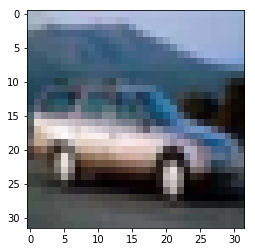

In [20]:
i = 4
print(CIFAR_class[int(np.squeeze(y_train[i]))])
plt.imshow(X_train[i])

## Densenet

### The pieces

Let's make some helper functions for piecing together our network using Keras' Functional API.

These components should all be familiar to you:
* Relu activation
* Dropout regularization
* Batch-normalization

Convolutional layer:
* L2 Regularization
* 'same' border mode returns same width/height
* Pass output through Dropout


Define ConvBlock as sequence:
* Batchnorm
* ReLU Activation
* Conv layer (conv w/ Dropout)

The authors also use something called a *bottleneck* layer to reduce dimensionality of inputs. 

Recall that the filter space dimensionality grows at each block. The input dimensionality will determine the dimensionality of your convolution weight matrices, i.e. # of parameters.

At size 3x3 or larger, convolutions can become extremely costly and # of parameters can increase quickly as a function of the input feature (filter) space. Therefore, a smart approach is to reduce dimensionality of filters by using a 1x1 convolution w/ smaller # of filters before the larger convolution.

Bottleneck consists of:
* 1x1 conv
* Compress # of filters into growth factor `nf` * 4
* Batchnorm -> ReLU

In [36]:
def conv_block(x, nf, bottleneck=False, p=None, wd=0.):
    
    if bottleneck:
        x = Activation('relu')(BatchNormalization()(x))
        x = Conv2D(nf*4, (1,1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(wd))(x)
        x = Dropout(p)(x)
        
    x = Activation('relu')(BatchNormalization()(x))
    x = Conv2D(nf, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(wd))(x)
    x = Dropout(p)(x)
    return x

Now we can define the dense block:
* Take given input `x`
* Pass through a conv block for output `b`
* Concatenate input `x` and conv block output `b`
* Set concatenation as new input `x` for next block
* Repeat

In [37]:
def dense_block(x, n_layers, growth_rate, bottleneck=False, p=None, wd=0.):
    if bottleneck: n_layers//=2
    
    for l in range(n_layers):
        b = conv_block(x, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        x = Concatenate(axis=-1)([x, b])
    return x

As typical for CV architectures, we'll do some pooling after computation.

We'll define this unit as the transition block, and we'll put one between each dense block.

Aside from BN -> ReLU and Average Pooling, there is also an option for filter *compression* in this block. This is simply feature reduction via 1x1 conv as discussed before, where the new # of filters is a percentage of the incoming # of filters.

Together with bottleneck, compression has been shown to improve performance and computational efficiency of DenseNet architectures. (the authors call this DenseNet-BC)

In [57]:
def transition_block(x, compression=1.0, p=None, wd=0.):
    nf = int(int(x.get_shape().as_list()[-1]) * compression)
    x = BatchNormalization()(x)
    x = Conv2D(nf, (1,1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(wd))(x)
    x = Dropout(p)(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    return x

### Build the DenseNet model

We've now defined all the building blocks (literally) to put together a DenseNet.

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: total number of layers 
    - Includes 4 extra non-block layers
        - 1 input conv, 3 output layers
- nb_block: number of dense blocks (generally = 3). 
    - NOTE: Layers / block are evenly allocated. Therefore nb_block must be a factor of (Depth - 4)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- bottleneck: add bottleneck blocks
- Compression: Filter compression factor in transition blocks.
- p: dropout rate
- wd: weight decay
- activation: Type of activation at the top layer. Can be one of 'softmax' or 'sigmoid'. Note that if sigmoid is used, classes must be 1.

Returns: keras tensor with nb_layers of conv_block appended

From start to finish, this generates:
* Conv input layer
* Alternate between Dense/Transition blocks `nb_block` times, ommitting Transition block after last Dense block
    * Each Dense block has `(Depth-4)/nb_block` layers
* Pass final Dense block to BN -> ReLU
* Global Avg Pooling
* Dense layer w/ desired output activation

In [59]:
def create_dense_net(n_classes, img_input, depth=40, n_block=3, 
     growth_rate=12, n_filter=16, bottleneck=False, compression=1.0, p=None, wd=0, activation='softmax'):
    
    assert activation=='softmax' or activation=='sigmoid'
    assert (depth - 4) % n_block == 0
    
    n_layers_per_block = int((depth - 4) / n_block)
    n_layers = [n_layers_per_block] * n_block
    
    x = Conv2D(n_filter, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(wd))(img_input)
    x = Dropout(p)(x)
    
    for i, block in enumerate(n_layers):
        x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        if i != len(n_layers)-1:
            x = transition_block(x, compression=compression, p=p, wd=wd)
    
    x = Activation('relu')(BatchNormalization()(x))
    x = GlobalAveragePooling2D()(x)
    x = Dense(n_classes, activation=activation, kernel_regularizer=l2(wd))(x)
    return x

### Train

Now we can test it out on CIFAR-10.

In [29]:
input_shape = X_train.shape[1:]; input_shape

(32, 32, 3)

In [30]:
img_input = Input(shape=input_shape)

In [60]:
x = create_dense_net(10, img_input, depth=100, #n_block=3, growth_rate=12, activation='softmax'
     n_filter=16, bottleneck=True, compression=0.5, p=1e-4, wd=0.2)

transition_block nf: 104
transition_block nf: 148


In [61]:
model = Model(img_input, x)

In [65]:
model.compile(keras.optimizers.SGD(0.1, 0.9, nesterov=True), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [66]:
parms = {'verbose': 2, 'callbacks': [TQDMNotebookCallback()]}

In [67]:
K.set_value(model.optimizer.lr, 0.1)

This will likely need to run overnight + lr annealing...

In [ ]:
model.fit(X_train, y_train, 64, 20, validation_data=(X_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/20
